# Robyn: Marketing Mix Modeling Application

This notebook demonstrates the usage of Robyn, a Marketing Mix Modeling (MMM) application. 
We'll go through the main steps of performing robyn_inputs and robyn_engineering.



## 1. Import Required Libraries. Define Paths.

First, be sure to setup your virtual environment. Be sure to switch over to your new environment in this notebook. 

-```cd {root_folder}```

-```python3 -m yourvenv```

-```source yourvenv/bin/activate```

-```cd Robyn/python```

-```pip install -r requirements.txt```


Then import the necessary libraries. Make sure to define your paths below.



In [1]:
import sys

# Add Robyn to path
sys.path.append("/Users/yijuilee/robynpy_release_reviews/Robyn/python/src")

In [2]:
import os
import pandas as pd
import pyreadr
from typing import Dict
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.enums import AdstockType
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models
from robyn.modeling.feature_engineering import FeatureEngineering

2024-11-14 14:03:56,040 - robyn - INFO - Logging is set up to console only.
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1 Load Mock R data

We need to set the base path for the data directory.
Create a .env file in the same directory as your notebook and put in define the path to the data dir.
for example: ROBYN_BASE_PATH=.../Robyn/R/data

In [3]:
# Read the simulated data and holidays data
dt_simulated_weekly = pd.read_csv("resources/dt_simulated_weekly.csv")

dt_prophet_holidays = pd.read_csv("resources/dt_prophet_holidays.csv")

## Setup MMM Data

We will now set up the MMM data specification which includes defining the dependent variable, independent variables, and the time window for analysis.

In [4]:
def setup_mmm_data(dt_simulated_weekly) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="DATE",
        context_vars=["competitor_sales_B", "events"],
        paid_media_spends=["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"],
        paid_media_vars=["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"],
        organic_vars=["newsletter"],
        window_start="2016-01-01",
        window_end="2018-12-31",
        factor_vars=["events"],
    )

    return MMMData(data=dt_simulated_weekly, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(dt_simulated_weekly)
mmm_data.data.head()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,2015-11-23,2.754372e+06,22358.346667,0.0,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2015-11-30,2.584277e+06,28613.453333,0.0,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,2015-12-07,2.547387e+06,0.000000,132278.4,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,2015-12-14,2.875220e+06,83450.306667,0.0,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,2015-12-21,2.215953e+06,0.000000,277336.0,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000


## Feature Preprocessing

We will perform feature engineering to prepare the data for modeling. This includes transformations like adstock and other preprocessing steps.

In [5]:
hyperparameters = Hyperparameters(
    hyperparameters={
        "facebook_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "print_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "tv_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.3, 0.8],
        ),
        "search_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0, 0.3],
        ),
        "ooh_S": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
        "newsletter": ChannelHyperparameters(
            alphas=[0.5, 3],
            gammas=[0.3, 1],
            thetas=[0.1, 0.4],
        ),
    },
    adstock=AdstockType.GEOMETRIC,
    lambda_=0.0,
    train_size=[0.5, 0.8],
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [6]:
# Create HolidaysData object
holidays_data = HolidaysData(
    dt_holidays=dt_prophet_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="DE",
    prophet_signs=["default", "default", "default"],
)
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)

In [7]:
# Setup FeaturizedMMMData
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2024-11-14 14:03:58,356 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2024-11-14 14:03:58,359 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2024-11-14 14:03:58,359 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
/Users/yijuilee/robynpy_release_reviews/robynvenv/lib/python3.9/site-packages/prophet/forecaster.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
2024-11-14 14:03:59,094 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnwc0000gn/T/tmpswsvpq2h/8wo33geu.json
2024-11-14 14:03:59,104 - cmdstanpy - DEBUG - input tempfile: /var/folders/gm/g5cpl7110m96nfd1qr1xwnw

2024-11-14 14:03:59,338 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2024-11-14 14:03:59,339 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: facebook_I
2024-11-14 14:03:59,506 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel facebook_I


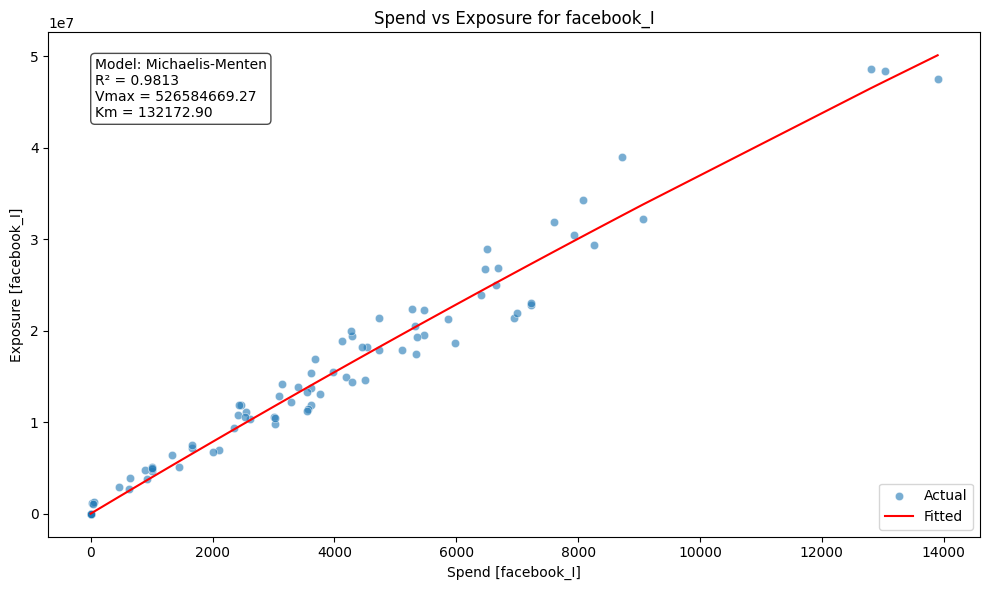

2024-11-14 14:03:59,604 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: search_clicks_P
2024-11-14 14:03:59,767 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel search_clicks_P


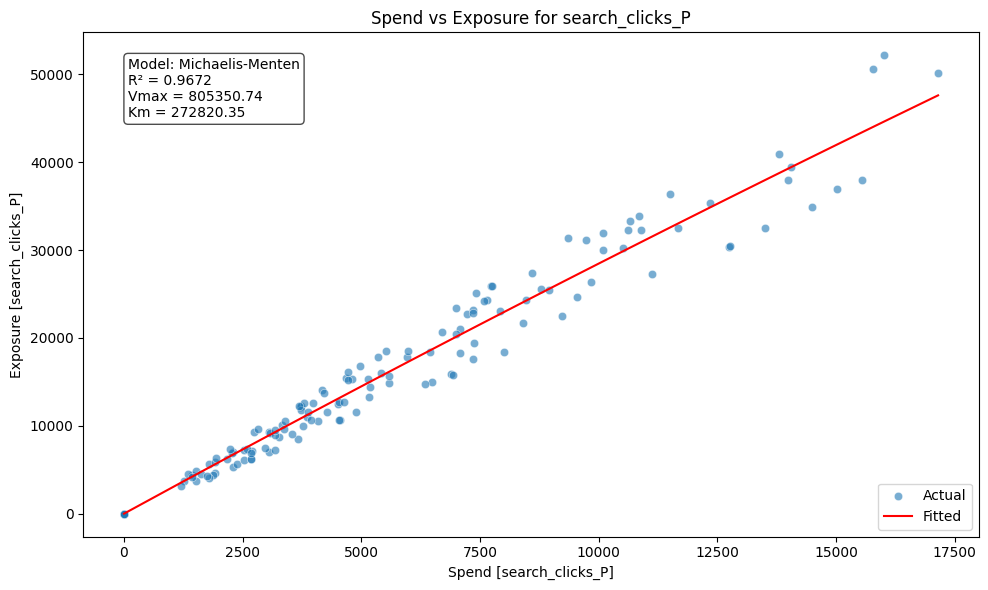

In [8]:
from robyn.visualization.feature_visualization import FeaturePlotter
import matplotlib.pyplot as plt
%matplotlib inline

# Create a FeaturePlotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters)
# Extract the list of results
results_list = featurized_mmm_data.modNLS["results"]
# Plot spend-exposure relationship for each channel in the results
for result in results_list:
    channel = result["channel"]
    try:
        fig = feature_plotter.plot_spend_exposure(featurized_mmm_data, channel)
        plt.show()
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")

In [9]:
from utils.data_mapper import load_data_from_json, import_input_collect

# Load data from JSON exported from R
raw_input_collect = load_data_from_json(
    "/Users/yijuilee/project_robyn/original/Robyn_original_2/Robyn/robyn_api/data/Feature_InputCollect.json"
)

# Convert R data to Python objects
r_input_collect = import_input_collect(raw_input_collect)

# Extract individual components
r_mmm_data = r_input_collect["mmm_data"]
r_featurized_mmm_data = r_input_collect["featurized_mmm_data"]
r_holidays_data = r_input_collect["holidays_data"]
r_hyperparameters = r_input_collect["hyperparameters"]

In [10]:
print(featurized_mmm_data.dt_mod["events"].unique())

print(r_featurized_mmm_data.dt_mod["events"].unique())

[      0.         1272202.89877032  447056.27859032]
[      0.         1272202.89877032  447232.65809817]


In [11]:
import pandas as pd

# Assuming featurized_mmm_data and r_featurized_mmm_data are your DataFrames
# and they have been defined and populated with data
# Calculate descriptive statistics for both DataFrames
python_stats = featurized_mmm_data.dt_mod[
    ["trend", "season", "holiday", "events"]
].describe()
r_stats = r_featurized_mmm_data.dt_mod[
    ["trend", "season", "holiday", "events"]
].describe()
print(python_stats)
print(r_stats)
# Define a tolerance level for comparison
tolerance = 1000


# Function to compare two DataFrames
def compare_stats(python_stats: pd.DataFrame, r_stats: pd.DataFrame, tolerance: float):
    # Iterate over each column and statistic
    for column in python_stats.columns:
        for stat in python_stats.index:
            python_value = python_stats.loc[stat, column]
            r_value = r_stats.loc[stat, column]
            # Assert that the values are within the specified tolerance
            assert abs(python_value - r_value) <= tolerance, (
                f"Difference in {stat} for {column} exceeds tolerance: "
                f"Python value = {python_value}, R value = {r_value}"
            )


# Compare the statistics
compare_stats(python_stats, r_stats, tolerance)
print("All statistics are within the specified tolerance.")

              trend        season       holiday        events
count  2.080000e+02  2.080000e+02  2.080000e+02  2.080000e+02
mean   1.772974e+06 -4.203860e+03  4.491105e+04  8.265669e+03
std    2.839704e+04  6.756266e+05  1.790185e+05  9.335788e+04
min    1.715494e+06 -1.050359e+06 -3.372642e+05  0.000000e+00
25%    1.748984e+06 -6.738105e+05  0.000000e+00  0.000000e+00
50%    1.774054e+06 -5.964066e+04  0.000000e+00  0.000000e+00
75%    1.798442e+06  6.469059e+05  0.000000e+00  0.000000e+00
max    1.814898e+06  1.218389e+06  1.054990e+06  1.272203e+06
              trend        season       holiday        events
count  2.080000e+02  2.080000e+02  2.080000e+02  2.080000e+02
mean   1.773156e+06 -4.203883e+03  4.493476e+04  8.266517e+03
std    2.839524e+04  6.756344e+05  1.790962e+05  9.336189e+04
min    1.715453e+06 -1.050414e+06 -3.374564e+05  0.000000e+00
25%    1.749216e+06 -6.738250e+05  0.000000e+00  0.000000e+00
50%    1.774229e+06 -5.961828e+04  0.000000e+00  0.000000e+00
75%    1

In [12]:
print(featurized_mmm_data.dt_modRollWind["events"].unique())

print(r_featurized_mmm_data.dt_modRollWind["events"].unique())

[      0.         1272202.89877032]
[      0.         1272202.89877032]


In [13]:
# Convert 'yhat' lists to DataFrames for comparison
yhat1_df = pd.DataFrame(featurized_mmm_data.modNLS["yhat"])
yhat2_df = pd.DataFrame(r_featurized_mmm_data.modNLS["yhat"])

# Print the shape and a quick preview of 'yhat' DataFrames
print("Shape of 'yhat' from modNLS1:", yhat1_df.shape)
print("Preview of 'yhat' from modNLS1:")
print(yhat1_df.head())

print("\nShape of 'yhat' from modNLS2:", yhat2_df.shape)
print("Preview of 'yhat' from modNLS2:")
print(yhat2_df.head())

# Describe the numeric columns to compare distributions
print("\nDescription of 'yhat' from modNLS1:")
print(yhat1_df.describe())

print("\nDescription of 'yhat' from modNLS2:")
print(yhat2_df.describe())

Shape of 'yhat' from modNLS1: (628, 6)
Preview of 'yhat' from modNLS1:
             x             y          yhat     channel models         ds
0  3623.012233  1.371590e+07  1.404919e+07  facebook_I    nls 2016-01-04
1  4129.816153  1.885156e+07  1.595491e+07  facebook_I    nls 2016-01-11
2  3623.012233  1.191019e+07  1.404919e+07  facebook_I    nls 2016-01-18
3  3002.690585  1.062042e+07  1.169716e+07  facebook_I    nls 2016-01-25
4     0.000000  0.000000e+00  0.000000e+00  facebook_I    nls 2016-02-01

Shape of 'yhat' from modNLS2: (628, 6)
Preview of 'yhat' from modNLS2:
      channel             y          x models          yhat          ds
0  facebook_I  1.371590e+07  3623.0122    nls  1.362829e+07  2016-01-04
1  facebook_I  1.371590e+07  3623.0122     lm  1.362829e+07  2016-01-11
2  facebook_I  1.885156e+07  4129.8162    nls  1.553468e+07  2016-01-18
3  facebook_I  1.885156e+07  4129.8162     lm  1.553468e+07  2016-01-25
4  facebook_I  1.191019e+07  3623.0122    nls  1.362829e+07

In [14]:
import numpy as np
import pandas as pd


def compare_modNLS(modNLS1, modNLS2, tolerance=1e-1, percent_tolerance=5):
    # Print available channels for debugging
    channels1 = [result["channel"] for result in modNLS1["results"]]
    channels2 = [result["channel"] for result in modNLS2["results"]]
    print("Channels in modNLS1:", channels1)
    print("Channels in modNLS2:", channels2)

    # Print the structure of 'results' for debugging
    print("\nStructure of 'results' in modNLS1:")
    for result in modNLS1["results"]:
        print(result)

    print("\nStructure of 'results' in modNLS2:")
    for result in modNLS2["results"]:
        print(result)

    # Compare 'results' section
    for result1 in modNLS1["results"]:
        channel = result1["channel"]
        result2 = next((r for r in modNLS2["results"] if r["channel"] == channel), None)
        assert result2 is not None, f"Channel {channel} not found in second modNLS"

        # Compare R-squared values separately
        assert np.isclose(
            result1["rsq_nls"], result2["rsq_nls"], atol=tolerance
        ), f"R-squared (NLS) mismatch for {channel}: {result1['rsq_nls']} vs {result2['rsq_nls']}"

        assert np.isclose(
            result1["rsq_lm"], result2["rsq_lm"], atol=tolerance
        ), f"R-squared (LM) mismatch for {channel}: {result1['rsq_lm']} vs {result2['rsq_lm']}"

        # Compare coefficients
        for coef_key in ["Vmax", "Km", "coef_lm"]:
            coef_value1 = result1.get(coef_key)
            coef_value2 = result2.get(coef_key)
            assert (
                coef_value2 is not None
            ), f"Coefficient {coef_key} not found for {channel}"
            assert np.isclose(
                coef_value1, coef_value2, atol=tolerance
            ), f"Coefficient {coef_key} mismatch for {channel}: {coef_value1} vs {coef_value2}"

    # Convert 'yhat' lists to DataFrames for comparison
    yhat1_df = (
        pd.DataFrame(modNLS1["yhat"])
        .sort_values(by=["ds", "channel"])
        .reset_index(drop=True)
    )
    yhat2_df = (
        pd.DataFrame(modNLS2["yhat"])
        .sort_values(by=["ds", "channel"])
        .reset_index(drop=True)
    )

    # Print preview of 'yhat' DataFrames
    print("Preview of 'yhat' from modNLS1:")
    print(yhat1_df.head())
    print("\nPreview of 'yhat' from modNLS2:")
    print(yhat2_df.head())

    # Compare 'yhat' DataFrame
    assert yhat1_df.shape == yhat2_df.shape, "Shape mismatch in 'yhat' DataFrame"

    # Select only numeric columns for comparison
    numeric_cols = yhat1_df.select_dtypes(include=[np.number]).columns

    # Use describe to get summary statistics
    desc1 = yhat1_df[numeric_cols].describe()
    desc2 = yhat2_df[numeric_cols].describe()

    # Compare each statistic separately
    for stat in desc1.index:
        for col in numeric_cols:
            val1 = desc1.at[stat, col]
            val2 = desc2.at[stat, col]
            if not np.isclose(val1, val2, rtol=percent_tolerance):
                print(f"Mismatch in {stat} of column '{col}': {val1} vs {val2}")
                raise AssertionError(f"Mismatch in {stat} of column '{col}'")

    print("All comparisons passed within the specified tolerance.")


# Example usage
compare_modNLS(featurized_mmm_data.modNLS, r_featurized_mmm_data.modNLS)

Channels in modNLS1: ['facebook_I', 'search_clicks_P']
Channels in modNLS2: ['facebook_I', 'search_clicks_P']

Structure of 'results' in modNLS1:
{'channel': 'facebook_I', 'model_type': 'nls', 'Vmax': 526584669.26527345, 'Km': 132172.89890426732, 'aic_nls': np.float64(-63.03286895577898), 'aic_lm': np.float64(-65.13153318475403), 'bic_nls': np.float64(-56.920377345082365), 'bic_lm': np.float64(-62.07528737940572), 'rsq_nls': np.float64(0.9813499753637182), 'rsq_lm': np.float64(0.9804068584994678), 'coef_lm': 3761.5919579945594, 'rsq': np.float64(0.9813499753637182)}
{'channel': 'search_clicks_P', 'model_type': 'nls', 'Vmax': 805350.7410810068, 'Km': 272820.351177426, 'aic_nls': np.float64(-36.82819579713845), 'aic_lm': np.float64(-38.85764187253047), 'bic_nls': np.float64(-30.715704186441833), 'bic_lm': np.float64(-35.80139606718217), 'rsq_nls': np.float64(0.9671527949952451), 'rsq_lm': np.float64(0.9666656067125566), 'coef_lm': 2.8424388952904276, 'rsq': np.float64(0.9671527949952451)

In [15]:
print(featurized_mmm_data.modNLS.keys())

for key in featurized_mmm_data.modNLS:
    print(f"\nKey: {key}")
    print(f"Type: {type(featurized_mmm_data.modNLS[key])}")
    if isinstance(featurized_mmm_data.modNLS[key], list):
        print(f"Number of items: {len(featurized_mmm_data.modNLS[key])}")
        if len(featurized_mmm_data.modNLS[key]) > 0:
            print("Sample item:", featurized_mmm_data.modNLS[key][0])
    elif isinstance(featurized_mmm_data.modNLS[key], dict):
        print("Sample keys:", list(featurized_mmm_data.modNLS[key].keys()))
        if len(featurized_mmm_data.modNLS[key]) > 0:
            first_key = next(iter(featurized_mmm_data.modNLS[key]))
            print("Sample item:", featurized_mmm_data.modNLS[key][first_key])
    else:
        print("Value:", featurized_mmm_data.modNLS[key])

dict_keys(['results', 'yhat', 'plots'])

Key: results
Type: <class 'list'>
Number of items: 2
Sample item: {'channel': 'facebook_I', 'model_type': 'nls', 'Vmax': 526584669.26527345, 'Km': 132172.89890426732, 'aic_nls': np.float64(-63.03286895577898), 'aic_lm': np.float64(-65.13153318475403), 'bic_nls': np.float64(-56.920377345082365), 'bic_lm': np.float64(-62.07528737940572), 'rsq_nls': np.float64(0.9813499753637182), 'rsq_lm': np.float64(0.9804068584994678), 'coef_lm': 3761.5919579945594, 'rsq': np.float64(0.9813499753637182)}

Key: yhat
Type: <class 'list'>
Number of items: 628
Sample item: {'x': 3623.01223287033, 'y': 13715898.6058832, 'yhat': 14049191.042750835, 'channel': 'facebook_I', 'models': 'nls', 'ds': Timestamp('2016-01-04 00:00:00')}

Key: plots
Type: <class 'dict'>
Sample keys: ['facebook_I', 'search_clicks_P']
Sample item:            spend      exposure          yhat
6    3623.012233  1.371590e+07  1.404919e+07
7    4129.816153  1.885156e+07  1.595491e+07
8    3623.01223

In [16]:
channel_name = "facebook_S"  # Example channel name
results = featurized_mmm_data.modNLS.get("results", [])
channel_data = next((item for item in results if item["channel"] == channel_name), None)
if channel_data:
    print(f"\nData for channel {channel_name}:")
    print(channel_data)
else:
    print(f"No data found for channel {channel_name}.")

No data found for channel facebook_S.
